In [1]:
#Figure 2C,F graph plotting 
#v1.0 version, this is the first consolidation of analysis done so far
#Requires the environment packages found in 23pubenv

In [3]:
#General Import Packages: 
#Plotting
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import seaborn as sns
import trackpy as tp

#Numerics, model implementation, path management, extras: 
import numpy as np
import pandas as pd
from pathlib import Path
import random as rand
from tqdm import tqdm 
from scipy.special import erfc

#Signal Analysis Functions: 
from scipy.signal import savgol_filter
from scipy.signal import peak_widths
from scipy.optimize import curve_fit

In [4]:
#Custom function to read in centroid arrays into dataframe instead of as a string: 
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [5]:
#Defining a basic power law function to fit to our wave relations r^2:
def func_powerlaw(x, a, m):
    return m*x**a

In [6]:
#Importing the relevant data frames is done using the following structure: 

#Set the base path as the root for an analysis set, all sets are arranged where images and analysis outputs are in the following locations: 
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
base_path = Path.cwd().parent / 'Data Sets/2023_01_24_main-set'
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

#There are three important dataframes used in analysis, the wave data frame, the ARCOS df, and the tracking df with binnned calcium values:
#The tracking is the most broad, followed by ARCOS and then the wave (most abstracted info):
wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])
arcos_dataframe_paths = sorted(analysis_output_destination.glob('*_ARCOS_df.csv'), key=lambda x: x.stem.split('_')[0])
tracking_dataframe_paths = sorted(analysis_output_destination.glob('*_tracking_binned_df.csv'), key=lambda x:x.stem.split('_')[0])


In [7]:
#If things get to unweildly for using big csv files alone, consider: 
#https://arrow.apache.org/docs/python/feather.html
#https://github.com/apache/arrow

In [8]:
#To consolodate all the wave dataframes in a set, use the following function: 
#INPUT: Sorted list of all wave dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv wave DFs in the path list

def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

In [9]:
#To consolodate all the ARCOS dataframes in a set, use the following function: 
#INPUT: Sorted list of all ARCOS dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv arcos DFs in the path list

def consolidate_arcos(ARCOS_DF_PATHS, save_DF = False):
    
    arcos_collect = []

    for arcos_df_path in tqdm(ARCOS_DF_PATHS):
        img_id = int(arcos_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        arcos_df = pd.read_csv(arcos_df_path) #Open the arcos_DF from step3 analysis
        arcos_df = arcos_df[arcos_df.columns.drop(list(arcos_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = arcos_df['clTrackID'].values #Get the collective track values in the wave
        arcos_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        arcos_df['image_ID'] = [img_id for i in range(len(arcos_df))]
        arcos_collect.append(arcos_df)
    
    arcos_df_collected = pd.concat(arcos_collect, ignore_index=True)
    
    if save_DF:
        arcos_df_collected.to_csv(ARCOS_DF_PATHS[0].parent / 'combined_arcos_DF.csv', index=False)
        
    return arcos_df_collected

In [10]:
#To consolodate all the tracking dataframes in a set, use the following function: 
#INPUT: Sorted list of all tracking dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv tracking DFs in the path list

def consolidate_tracking(TRACKING_DF_PATHS, save_DF = False):
    
    tracking_collect = []

    for tracking_df_path in tqdm(TRACKING_DF_PATHS):
        img_id = int(tracking_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        tracking_df = pd.read_csv(tracking_df_path) #Open the arcos_DF from step3 analysis
        tracking_df = tracking_df[tracking_df.columns.drop(list(tracking_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        tracking_df['image_ID'] = [img_id for i in range(len(tracking_df))]
        tracking_collect.append(tracking_df)
    
    tracking_df_collected = pd.concat(tracking_collect, ignore_index=True)
    
    if save_DF:
        tracking_df_collected.to_csv(TRACKING_DF_PATHS[0].parent / 'combined_tracking_DF.csv', index=False)
        
    return tracking_df_collected

In [11]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5, 'font.family': ['arial'], 'axes.linewidth':2})


In [12]:
wave_con_df = consolidate_waves(wave_dataframe_paths)

100%|██████████████████████████████████████████| 57/57 [00:00<00:00, 638.86it/s]


In [13]:
wave_con_df['real_time'] = wave_con_df['rel_time'] * 5.0 #5.0 is the time step for all image stacks taken in this work.

In [14]:
trackable_waves = wave_con_df[wave_con_df['trackable'] == True]


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(0, 0.5, 'Radius (um)')

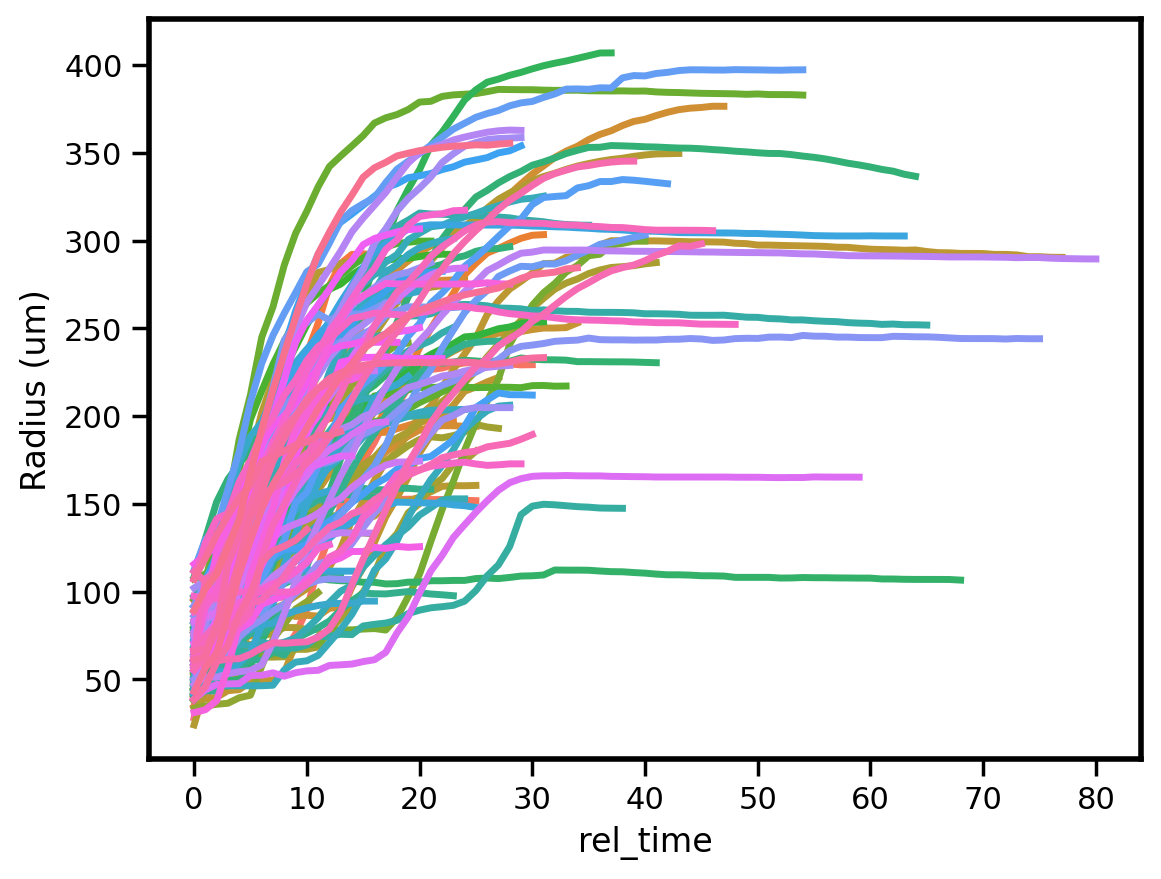

In [15]:
#Next are key wave analysis functions:
#Plotting all the early wave kinetics in a set
plt.figure(dpi=200)
sns.lineplot(data=trackable_waves, x='rel_time', y='circle_radius', hue='wave_ID', legend = False)
plt.ylabel('Radius (um)')

In [17]:
trackable_waves.wave_ID

0         26-1
1         26-1
2         26-1
3         26-1
4         26-1
         ...  
10244    88-60
10245    88-60
10246    88-60
10247    88-60
10248    88-60
Name: wave_ID, Length: 3606, dtype: object

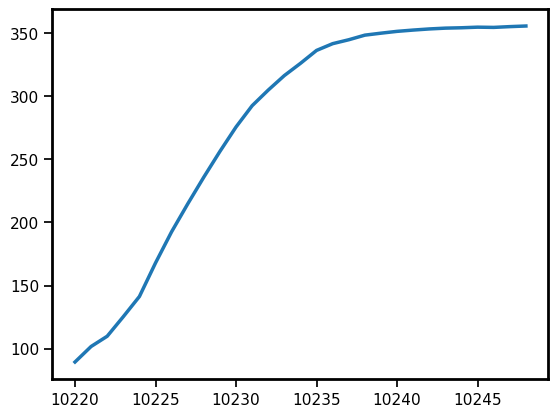

In [20]:
plt.plot(trackable_waves[trackable_waves['wave_ID'] == '88-60'].circle_radius)


/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(0, 0.5, 'Wave Front Radius (um)')

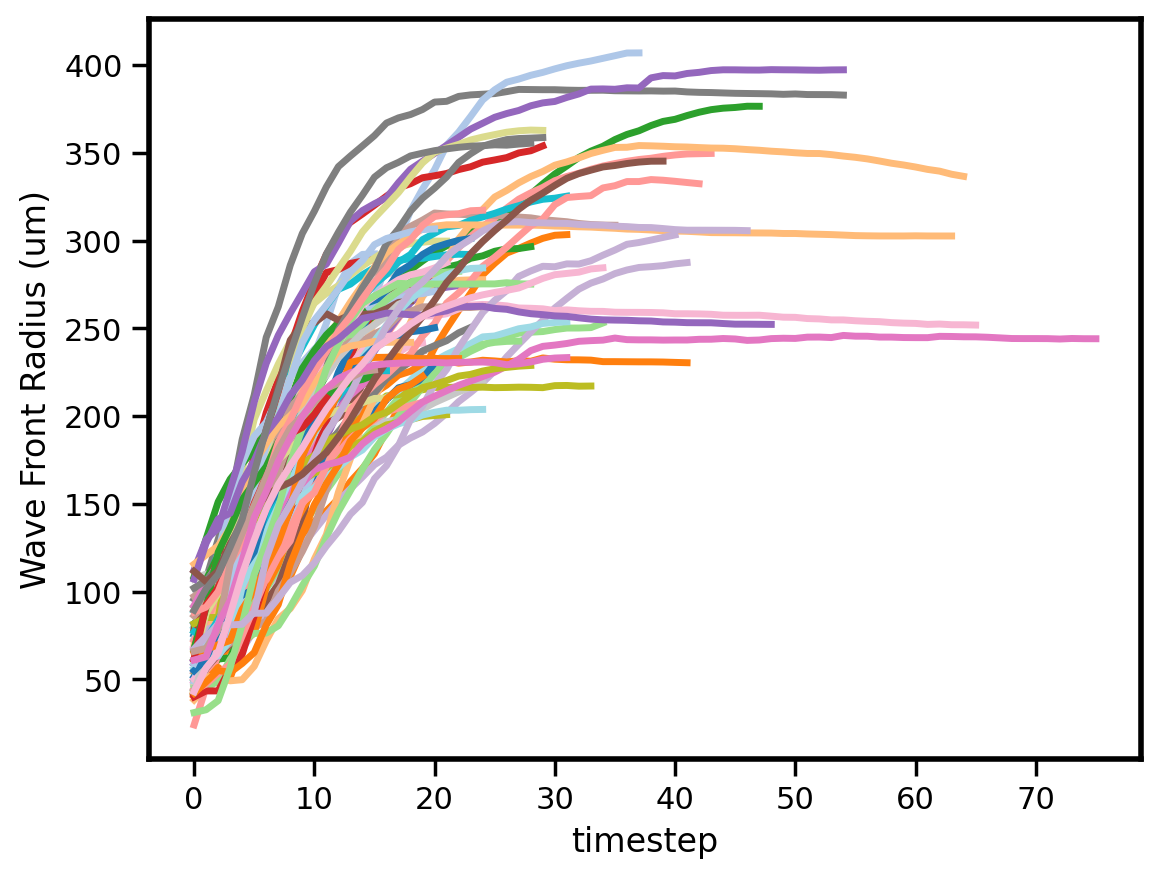

In [16]:
#There are three waves in this set that have strange kinetics, they are manually removed because they are tracking two waves that overlap, 
#or are so delayed from start track to actaul travel that they are exculed from further analysis:

#Waves with strange kinetics are in this list: 
wave_drop_list = ['85-6', '73-11', '69-3', '50-4', '57-11', '80-5', '61-9', '45-19', '40-4', '38-11', '83-15', '77-12', '33-5', '61-4', '38-14']
wave_whitelist = []
wave_blacklist = []
wave_too_small = []

wave_end_thresh_lower = 200

for wid,wave in trackable_waves.groupby('wave_ID'):
    if wid in wave_drop_list:
        wave['rel_r'] = wave['circle_radius'] - wave['circle_radius'].values[0]
        wave_blacklist.append(wave)
    else:
        #TEMP
        max_rad = wave['circle_radius'].max()
        if max_rad > wave_end_thresh_lower:
            wave['rel_r'] = wave['circle_radius'] - wave['circle_radius'].values[0]
            wave_whitelist.append(wave)
        else:
            wave['rel_r'] = wave['circle_radius'] - wave['circle_radius'].values[0]
            wave_too_small.append(wave)
        
clean_wave_tracks_DF = pd.concat(wave_whitelist, ignore_index=True)
excluded_wave_tracks_DF = pd.concat(wave_blacklist, ignore_index=True)
small_waves_DF = pd.concat(wave_too_small, ignore_index=True)


#These waves will be analyized: 
plt.figure(dpi=200)
sns.lineplot(data=clean_wave_tracks_DF, y='circle_radius', x='rel_time', hue='wave_ID', palette='tab20', legend=False)
plt.xlabel('timestep')
plt.ylabel('Wave Front Radius (um)')

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(0, 0.5, 'Wave Front Radius (um)')

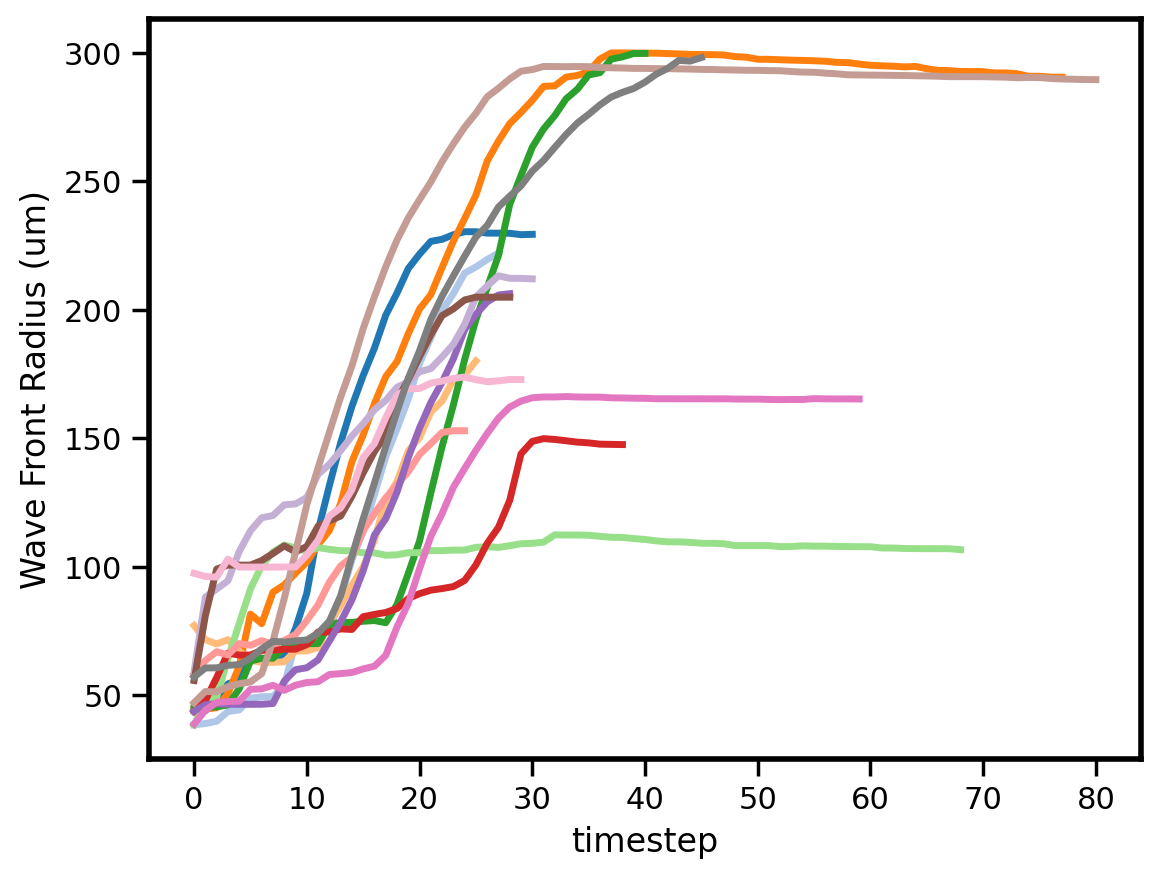

In [17]:
#These waves will not be analyzised:
plt.figure(dpi=200)
sns.lineplot(data=excluded_wave_tracks_DF, y='circle_radius', x='rel_time', hue='wave_ID', palette='tab20', legend=False)
plt.xlabel('timestep')
plt.ylabel('Wave Front Radius (um)')

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

Text(0, 0.5, 'Wave Front Radius (um)')

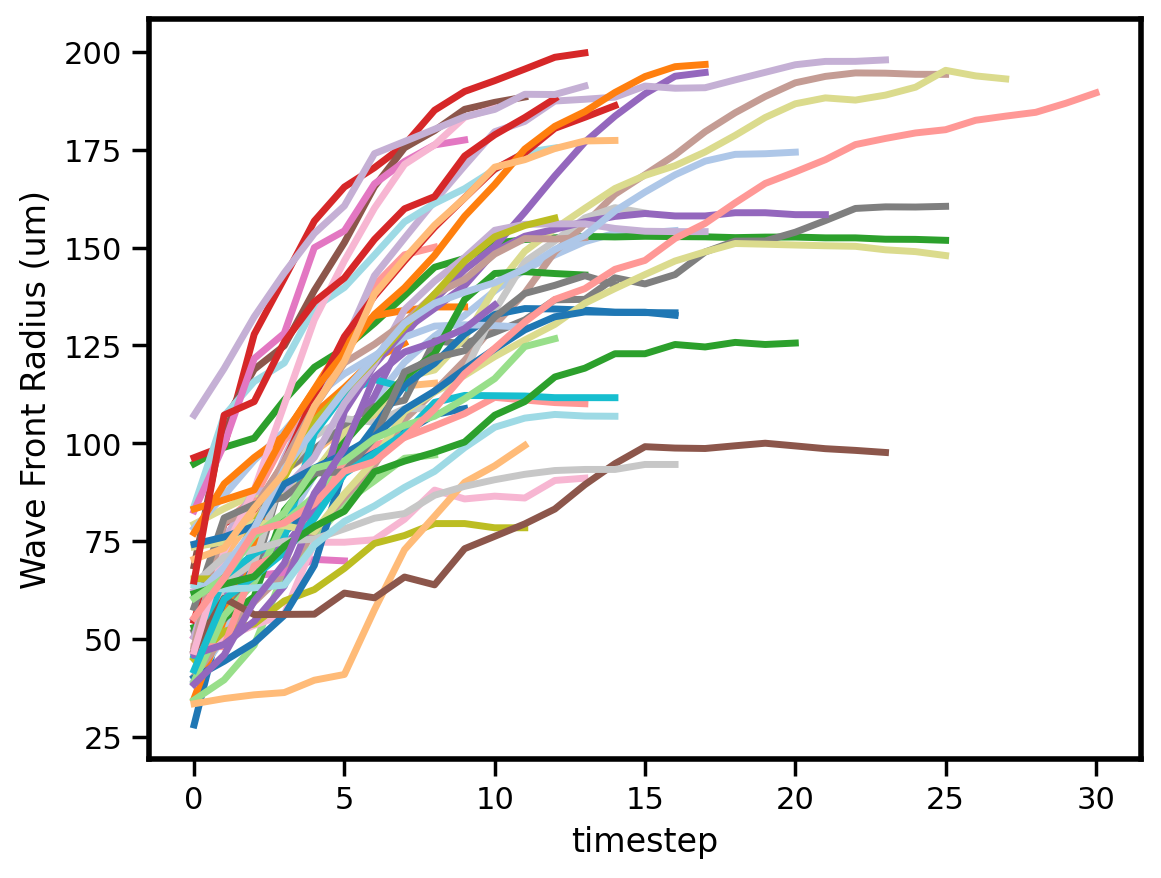

In [18]:
#These waves did not travel far enough to be further analyized: 
plt.figure(dpi=200)
sns.lineplot(data=small_waves_DF, y='circle_radius', x='rel_time', hue='wave_ID', palette='tab20', legend=False)
plt.xlabel('timestep')
plt.ylabel('Wave Front Radius (um)')

In [19]:
print("Included tracks")
print(len(clean_wave_tracks_DF['wave_ID'].unique()))
print("Excluded tracks bc delayed start")
print(len(excluded_wave_tracks_DF['wave_ID'].unique()))
print("Excluded tracks bc too small")
print(len(small_waves_DF['wave_ID'].unique()))

Included tracks
75
Excluded tracks bc delayed start
15
Excluded tracks bc too small
50


/var/folders/jb/q2707w2155s00qd5b8lpx_6m0000gn/T/ipykernel_49200/3322894007.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=single_wave,x='real_time', y='r_squared', ci='sd', label='Data')
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version.

Text(0, 0.5, 'Radius Squared (um^2)')

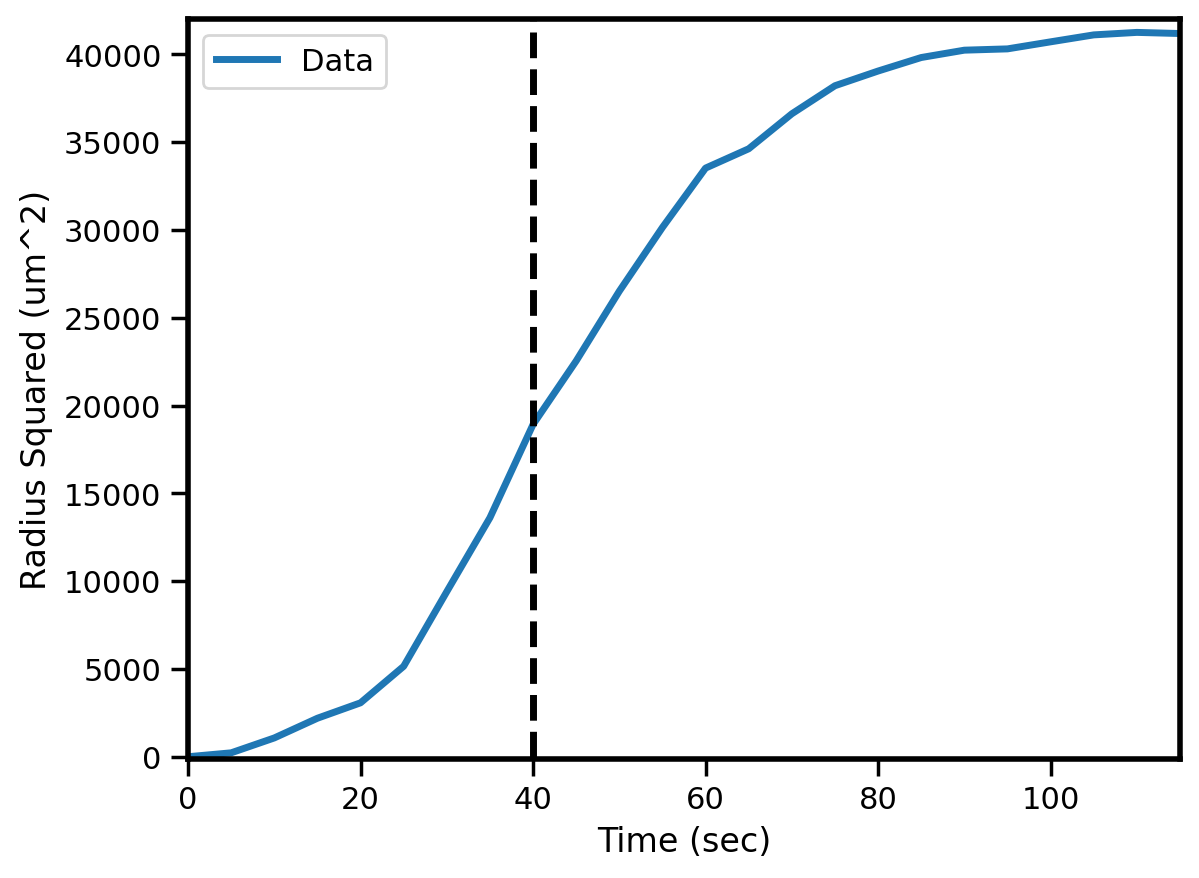

In [25]:
#plot the results with the title showing the fit parameters

single_wave = clean_wave_tracks_DF[clean_wave_tracks_DF['wave_ID'] == '47-61']
split_time = single_wave['split'].value_counts()[0.0] * 5.0

plt.figure(dpi=200)
sns.lineplot(data=single_wave,x='real_time', y='r_squared', ci='sd', label='Data')
plt.vlines(split_time,0,42000, colors='k', linestyles='--')
plt.legend()
plt.xlim(0,115)
plt.ylim(-100,42000)
plt.xlabel('Time (sec)')
plt.ylabel('Radius Squared (um^2)')

Text(0, 0.5, 'Average Calcium Signal (AU)')

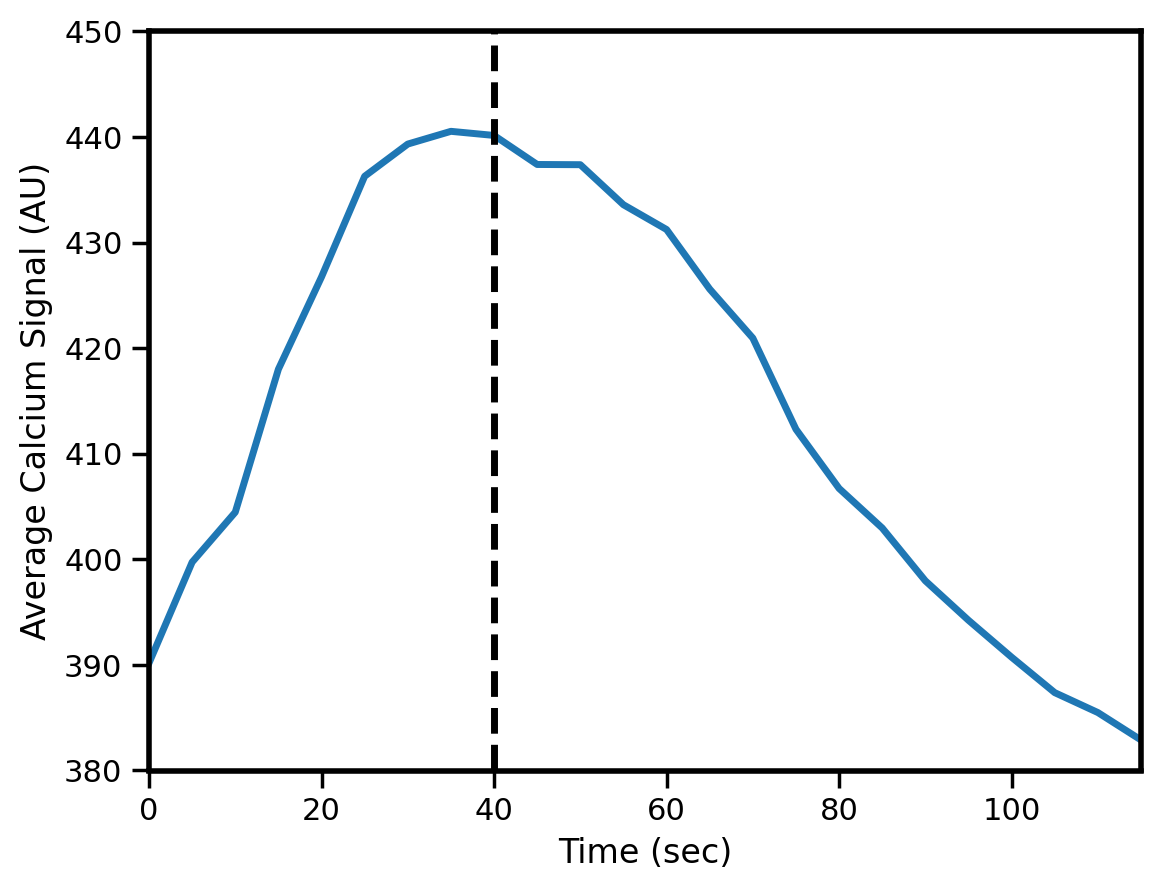

In [19]:
plt.figure(dpi=200)
plt.plot(single_wave['real_time'], single_wave['ca_avg_sig'])
plt.vlines(split_time,380,450, colors='k', linestyles='--')
plt.xlim(0,115)
plt.ylim(380,450)
plt.xlabel('Time (sec)')
plt.ylabel('Average Calcium Signal (AU)')

/var/folders/jb/q2707w2155s00qd5b8lpx_6m0000gn/T/ipykernel_95395/2928647771.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=clean_wave_tracks_DF,x='real_time', y='r_squared', ci='sd', label='Data')
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

Text(0, 0.5, 'Radius Squared (um^2)')

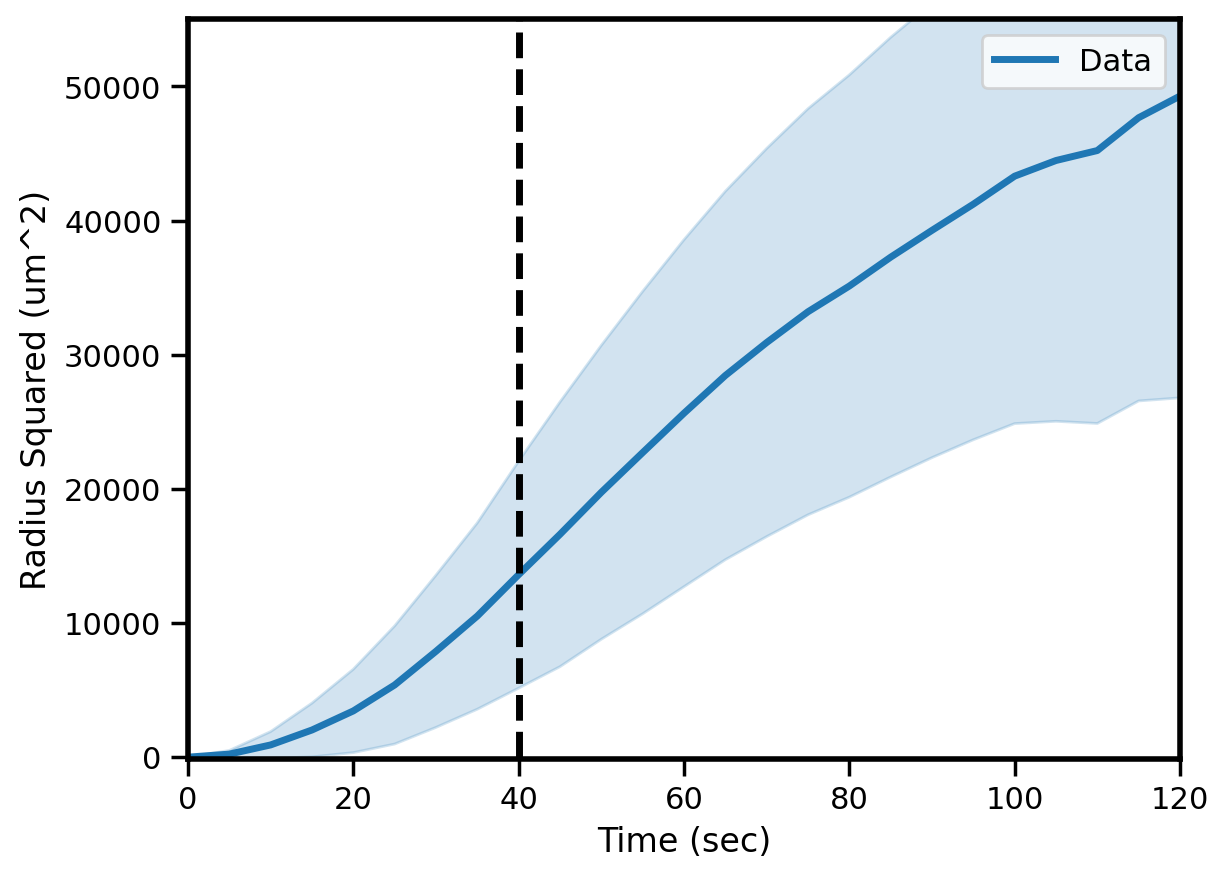

In [20]:
#plot the results with the title showing the fit parameters

plt.figure(dpi=200)
sns.lineplot(data=clean_wave_tracks_DF,x='real_time', y='r_squared', ci='sd', label='Data')
plt.vlines(split_time,0,55000, colors='k', linestyles='--')
plt.legend()
plt.xlim(0,120)
plt.ylim(-100,55000)
plt.xlabel('Time (sec)')
plt.ylabel('Radius Squared (um^2)')

In [21]:

clean_wave_tracks_DF.to_csv('wt_wave_fig2_DF.csv')


Text(0, 0.5, 'Number of waves in average')

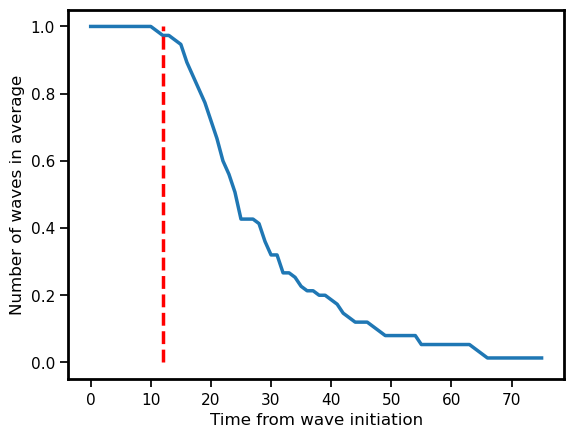

In [85]:
#We shouldnt draw a 'average wave distance from 0' when there is not full coverage
#wave coverage drops below 100% at time point 11, so only draw average out to time 12 (60s)
time_frame_i = []
num_waves = []

for t, tmpt in clean_wave_tracks_DF.groupby('rel_time'):
    time_frame_i.append(t)
    num_waves.append(len(tmpt.wave_ID.unique()))
    
num_waves = np.array(num_waves) / max(num_waves)
    
plt.plot(time_frame_i, num_waves)
plt.vlines([12], ymin = 0, ymax =1, color='red', linestyles='dashed')
plt.xlabel('Time from wave initiation')
plt.ylabel('Number of waves in average')

/var/folders/jb/q2707w2155s00qd5b8lpx_6m0000gn/T/ipykernel_86406/2706507175.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_initial['time_real'] = wave_initial['rel_time'] * 5.0
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ech

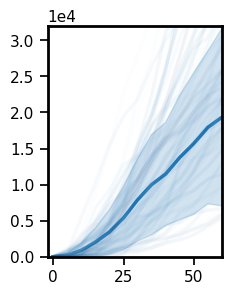

In [20]:
#Waves are split into growing and receeeding by their calcium signal in step4, 
#MAX CALCIUM peak as shown for example wave above. 
#This means we can look at wave starts and wave ends seperately by splitting our DF by when the split column is either 0 or 1:

#This is so we can also fit a power law to this data to see how its R^2 values evolve in time, 
#>1 is superdiffusive
#=1 is diffusive behavior
#<1 is subdiffuisive

#Get values for early wave kinetics, and enforce that 
wave_initial = clean_wave_tracks_DF[clean_wave_tracks_DF['split']==0]
wave_initial['time_real'] = wave_initial['rel_time'] * 5.0


#plot the results with the title showing the fit parameters
plt.figure(figsize=(2.25,3))
sns.lineplot(data=wave_initial,x='time_real', y='r_squared', errorbar='sd', label='Data', legend=False)
sns.lineplot(data=clean_wave_tracks_DF,x='real_time', y='r_squared', hue='wave_ID', palette='Blues', alpha=0.05, legend=False)
#plt.plot(t_interpol, func_powerlaw(t_interpol, *pars), linestyle='--', linewidth=2, color='black', label='Power Fit')
#plt.legend()
plt.xlim(-2,60)
plt.ylim(-2,32000)
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('fig2-early-wave-average-msd.png', dpi=400, bbox_inches='tight')
#plt.title('{}x^{}'.format(pars[1], pars[0]))

PosixPath('/Users/echo/Documents/Lab Stuff/Publication/23 Protofigures/Fig2 - Wave kinetics/diffusion relay compare/fits/WT_early_relay_fit.csv')

In [26]:
#Import early relay fit and the simple diffusion only core model fit: 
early_relay_fit = pd.read_csv(Path.cwd() / "diffusion relay compare/WT_early_relay_fit.csv")
early_simple_fit = pd.read_csv(Path.cwd() / "diffusion relay compare/WT_early_simple_fit.csv")


In [34]:
early_relay_fit['r_squared'] = early_relay_fit['r_relay'][1:]**2
early_simple_fit['r_squared'] = early_simple_fit['r_relay'][1:]**2

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

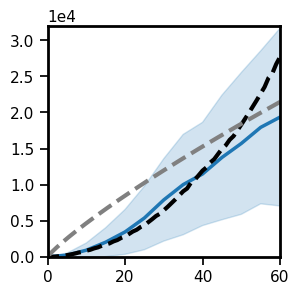

In [36]:
#Plotting figure 2e

#plot the results with the title showing the fit parameters
plt.figure(figsize=(3,3))
sns.lineplot(data=wave_initial,x='time_real', y='r_squared', errorbar='sd', label='Data', legend=False)
sns.lineplot(data=early_relay_fit,x='time', y='r_squared', color='black', linestyle='--', linewidth = 3, legend=False)
sns.lineplot(data=early_simple_fit,x='time', y='r_squared', color='grey', linestyle='--', linewidth = 3, legend=False)
#plt.plot(t_interpol, func_powerlaw(t_interpol, *pars), linestyle='--', linewidth=2, color='black', label='Power Fit')
#plt.legend()
plt.xlim(0,60)
plt.ylim(-2,32000)
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('fig2-early-wave-average-fits.png', dpi=400, bbox_inches='tight')
#plt.title('{}x^{}'.format(pars[1], pars[0]))

In [40]:
## This is where the analysis of individual wave tracks from the set are done. 
wave_fits = []
save_path = Path.cwd() / 'indiv_fits' / 'wt'

#Get values pre-split
wave_initial = clean_wave_tracks_DF[clean_wave_tracks_DF['split']==0]
wave_initial['time_real'] = wave_initial['rel_time'] * 5.0


sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

for wid, wave in wave_initial.groupby('wave_ID'):
    #Fit to our power law eq defined above where x=time, y=R^2
    #Because time will matter for fit, timestep to time is 5sec/frame:
    pars, cov = curve_fit(f=func_powerlaw, xdata=wave.real_time.values, ydata=wave.r_squared.values, p0=[1, 100])
    wave_fits.append([wid, pars[0], pars[1]])
    '''
    #plot the results with the title showing the fit parameters (normally i do this once and never again)
    t_interpol = np.linspace(0,wave.real_time.max(),100)
    plt.figure(figsize=(2.5,2.5), dpi=200)
    ax = sns.lineplot(data=wave,x='time_real', y='r_squared')
    ax.tick_params(direction='out', width=2, labelsize=10)
    plt.plot(t_interpol, func_powerlaw(t_interpol, *pars), linestyle='--', linewidth=2, color='black')
    plt.xlim(0,wave.time_real.max())
    plt.xlabel('')
    plt.ylabel('')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    f_name = save_path / str(str(wid) + '.png')
    plt.savefig(f_name, bbox_inches='tight', dpi=300)
    plt.close()
    '''
    
wave_fits_DF = pd.DataFrame(np.array(wave_fits, dtype=object), columns=['wid', 'alpha', 'm'])

/var/folders/jb/q2707w2155s00qd5b8lpx_6m0000gn/T/ipykernel_49200/972511945.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_initial['time_real'] = wave_initial['rel_time'] * 5.0


In [102]:
wave_fits_DF.to_csv('fig2-wt-individual-fits.csv')

In [103]:
#Repeat analysis with excluded small waves to ensure you aren't biasing the data by exclusion: 
wave_fits_smol = []

#Get values pre-split
wave_initial = small_waves_DF[small_waves_DF['split']==0]
wave_initial['time_real'] = wave_initial['rel_time'] * 5.0


sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

for wid, wave in wave_initial.groupby('wave_ID'):
    #Fit to our power law eq defined above where x=time, y=R^2
    #Because time will matter for fit, timestep to time is 5sec/frame:
    pars, cov = curve_fit(f=func_powerlaw, xdata=wave.real_time.values, ydata=wave.r_squared.values, p0=[1, 100])
    wave_fits_smol.append([wid, pars[0], pars[1]])

wave_fits_DF_smol = pd.DataFrame(np.array(wave_fits_smol, dtype=object), columns=['wid', 'alpha', 'm'])


/var/folders/jb/q2707w2155s00qd5b8lpx_6m0000gn/T/ipykernel_95395/3511574626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wave_initial['time_real'] = wave_initial['rel_time'] * 5.0
/var/folders/jb/q2707w2155s00qd5b8lpx_6m0000gn/T/ipykernel_95395/3599666436.py:3: RuntimeWarning: divide by zero encountered in power
  return m*x**a
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [104]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2, 'font.family': ['arial'], 'axes.linewidth':2})

/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/echo/miniconda3/envs/23pubenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

NameError: name 'wave_fits_DF_smol' is not defined

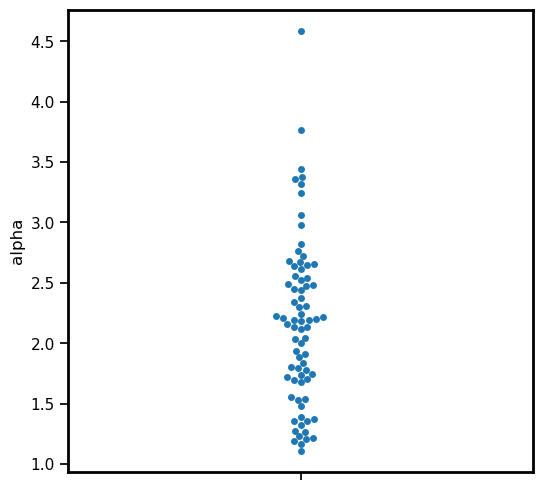

In [41]:
plt.figure(figsize=(6,6))
ax = sns.swarmplot(data=wave_fits_DF['alpha'])
ax = sns.swarmplot(data=wave_fits_DF_smol['alpha'])
#plt.vlines(wave_fits_DF.alpha.mean(), 0,12, colors='#B44744', linestyles='--')
plt.ylim(0,4.3)
plt.xlabel('')
plt.ylabel('')
ax.tick_params(direction='out', width=2, labelsize=20)
#plt.savefig('fig2-wt-individual-fit-hist.png', dpi=300, bbox_inches='tight')
#sns.displot(data=wave_fits_DF, x='alpha', kind="kde")

In [ ]:
#its the same image dot jpeg (that zero in the small category is obviously something off! 
#warning thrown above too probably some too short to fit to power law deal)